In [8]:
## CNN modeling
from __future__ import division,print_function

%load_ext autoreload

%autoreload 2
import torch
from torch import nn
from torchvision import transforms, datasets
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_predict
import pandas as pd
import cv2

data_path = '/home/harryzhang/Documents/athena_screen/images/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
## dataset genearating

# import glob
# import shutil



# read in radiomics data
radiomics = pd.read_csv('/home/harryzhang/Documents/athena_screen/radiomics_features.csv')
clinical_subset_unique = pd.read_csv('/home/harryzhang/Documents/athena_screen/clinical_subset_unique.csv')
# rename 0 column with image name
radiomics = radiomics.rename(columns={'0':'filename'})
# merge filename, label by filename
radiomics = pd.merge(radiomics,clinical_subset_unique[['filename','Cancer']],on='filename')

# # first put data into 0 and 1 sub-folder for pytorch Image folder function to assign label
vendors = radiomics[['filename','Cancer']]
vendors['filename'] = vendors['filename']+'.png'

# @deprecated
# os.mkdir(data_path+'processed/0/')
# os.mkdir(data_path+'processed/1/')
# paths = [data_path+'processed/0/',data_path+'processed/1/']

# for i in vendors.itertuples():
#     if i.Cancer == 0:
#         shutil.move(data_path+'processed/'+i.filename, paths[0])
#     else:
#         shutil.move(data_path+'processed/'+i.filename,paths[1])


# create transformation operations

        
transform_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(90),
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

dataset_transform = {'train':transform_train, 'test':transform_test}



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
## create cross validation foldes

from sklearn.model_selection import StratifiedKFold
import pickle
import os

num_folds = 10



# parameters
folds = []
outputf = '%s/indices_%s_fold.pkl' %(data_path,num_folds)

# check if the folder exist
if not os.path.exists(outputf):
    # create the stratified fold
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=100)
    for train_index,test_index in skf.split(vendors.filename,vendors.Cancer):
        folds.append(vendors.filename[test_index][:-4].tolist())

    # save the fold
    with open(outputf, 'wb') as f:
        pickle.dump(folds,f)
        
else:
    # load
    with open(outputf, 'rb') as f:
        folds = pickle.load(f) 

In [11]:
# create dataset combining all images

data = {}

for i in range(0,len(vendors)):
    label = vendors.Cancer[i]
    patient = vendors.filename[i]
    
    # load data
    img = cv2.imread(data_path+'processed/'+vendors.filename[0])
    
    data[patient] = {
        'imgs':img,
        'label':label
    }
    

In [ ]:
## examine transform function
from matplotlib.pyplot import imshow
aa = transform_train(data['f34ac05f73074db694109c24ee56bf17.png']['imgs'])
print(aa.shape)
print(data['f34ac05f73074db694109c24ee56bf17.png']['label'])

<IPython.core.display.Javascript object>


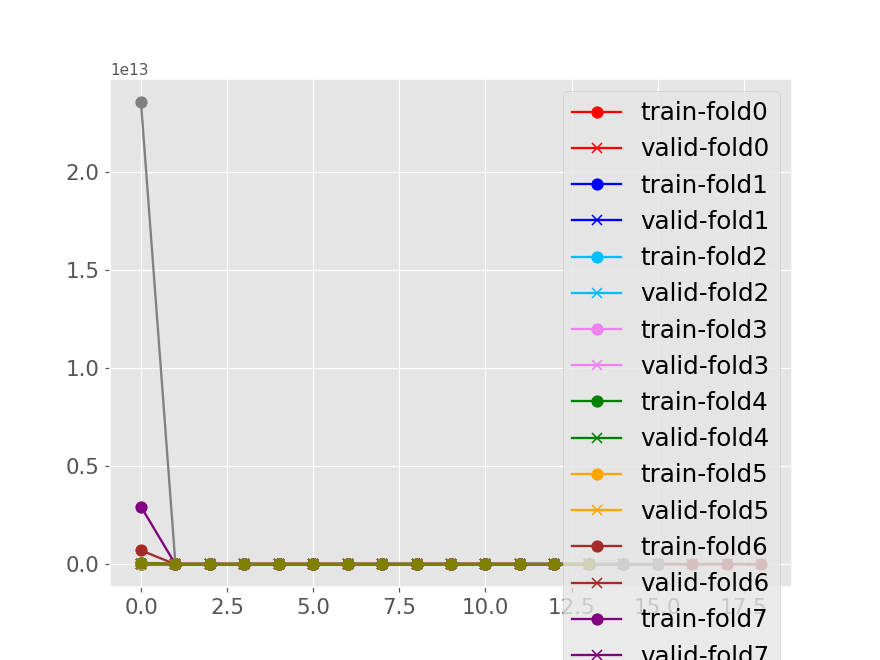

<IPython.core.display.Javascript object>


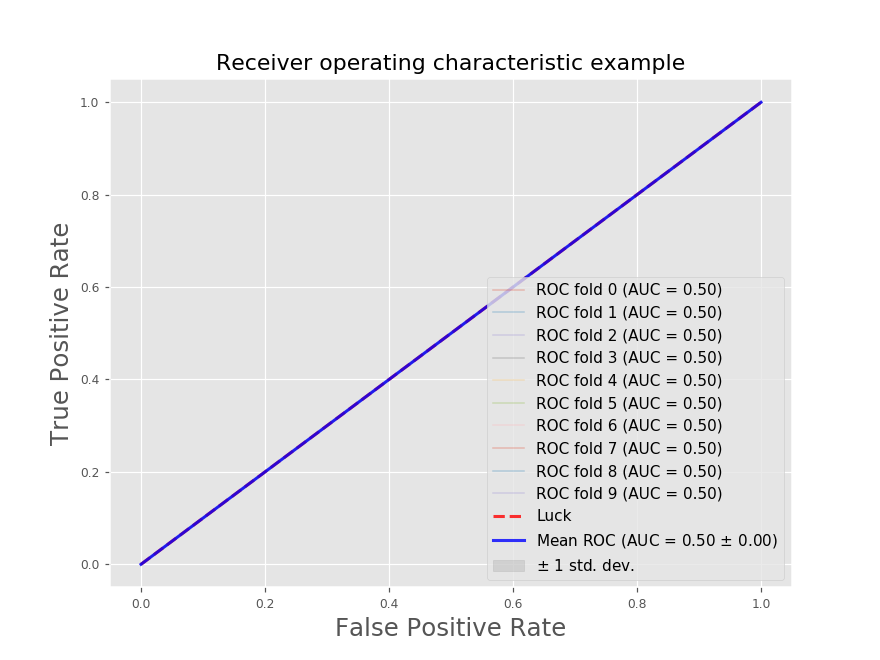


>>>>>>>>>>>>>>>>>>>> Fold: 0 >>>>>>>>>>>>>>>>>>>>
  epoch      train_loss    valid_acc    valid_loss    cp     dur
-------  --------------  -----------  ------------  ----  ------
      1  111625852.6273       0.3085    27798.6389     +  1.3332
      2  1284015.6583       0.6809  4592583.5703        1.2652
      3    76907.4509       0.6915     2331.1305     +  1.2619
      4    31545.7188       0.3085    16445.6429        1.3147
      5    13630.2849       0.6915     8736.9873        1.3355
      6  69789792.0769       0.6915   339963.7377        1.3043
      7  3051488.3893       0.6915    12791.4584        1.2606
      8     4378.6593       0.6915      337.7396     +  1.3254
      9      221.6920       0.6915      367.2163        1.3369
     10      204.2438       0.6915       66.4653     +  1.2695
     11      200.7956       0.3085       26.0298     +  1.2950
Stopping since valid_loss_best has not improved in the last 10 epochs.
tp: 37
fn: 0
tn: 0
fp: 16
test:fold0	accuracy:0.6981

tp: 37
fn: 0
tn: 0
fp: 15
test:fold5	accuracy:0.7115384615384616	precision:0.7115384615384616	recall:1.0	f1:0.8314606741573032	sensitivity:1.0	specificity:0.0	tpv:0.7115384615384616	npv:0.0	tpr:1.0	fpr:1.0	auc:0.5	

>>>>>>>>>>>>>>>>>>>> Fold: 6 >>>>>>>>>>>>>>>>>>>>
  epoch         train_loss    valid_acc    valid_loss    cp     dur
-------  -----------------  -----------  ------------  ----  ------
      1  709498785733.3300       0.3085       34.1135     +  1.2772
      2       19.0270       0.6915        6.3726     +  1.2736
      3        9.2790       0.6915        5.9358     +  1.3291
      4        3.9278       0.6915        4.7190     +  1.3180
      5        1.8957       0.6915        1.9118     +  1.3162
      6        1.1086       0.6915        1.0502     +  1.3167
      7        0.9316       0.6915        0.7554     +  1.3120
      8        0.7652       0.6915        0.7335     +  1.3123
      9        0.8106       0.6915        1.4274        1.2810
     10        1.0087     

In [12]:
%matplotlib notebook 

import torch.optim as optim
import torchvision.models as models
from lib.Utils import *
import collections
from functools import reduce
import skorch
from skorch import NeuralNetClassifier
from skorch.classifier import NeuralNetBinaryClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring,ProgressBar,Checkpoint,EarlyStopping
from sklearn.metrics import roc_auc_score
from itertools import chain
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np

plt.style.use('ggplot')

# set random seed
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed_all(100)
torch.backends.cudnn.deterministic=True


# ==================== train
# performance parameters
all_probs = [] # all test probabilities in cross validation
all_labels = [] # all test labels in cross validation


# plt setting
plt.ion()
fig_1 = plt.figure(figsize=(8,6), dpi=100)
axs_1 = fig_1.add_subplot(1,1,1)
fig_2 = plt.figure(figsize=(8,6), dpi=100)
axs_2 = fig_2.add_subplot(1,1,1)
losses = collections.OrderedDict()
markers = ['o','x']
colors = ['red','blue','deepskyblue','violet','green','orange','brown','purple','gray','olive']

# plt auc cross validation init
axs_2.clear()
axs_2.tick_params(labelsize=8)       
fig_2.show()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

CNN_model = models.alexnet(pretrained=True)

Cross_validation = True

if not Cross_validation:
    pass
else:
    # train cross validation version of the model
    for fold_index in range(0,len(folds)):
        print('')
        print('>>>>>>>>>>>>>>>>>>>> Fold: %s >>>>>>>>>>>>>>>>>>>>' % fold_index)

        # get the datasets and labels
        datasets, labels, dataloaders = get_train_test_dataset(folds, fold_index,data, dataset_transform)
        
        #progressBar = ProgressBar(postfix_keys=['train_loss','valid_loss'])
        #epochScoring = EpochScoring(scoring='roc_auc',lower_is_better = False)
        earlyStopping = EarlyStopping(monitor='valid_loss_best', patience=10)
        
        #valid_ds = skorch.dataset.Dataset(datasets['test'],labels['test'])
        
        net = NeuralNetClassifier(
            CNN_model,
            criterion = nn.CrossEntropyLoss,
            lr = 0.05,
            optimizer = optim.Adam,
            max_epochs = 50,
            batch_size = 10,
            optimizer__weight_decay=0.0005,
            warm_start=False,
            callbacks = [#progressBar,
                         #epochScoring,
                         earlyStopping,
                         Checkpoint,
                        ],
            iterator_train__shuffle=True,
            iterator_train__num_workers=4,
            iterator_valid__shuffle=False,
            iterator_valid__num_workers=4,
            #train_split = predefined_split(valid_ds),
            device = 'cuda',
        )
        
        # change net name
        net.fit(datasets['train'], labels['train'])
        y_test_proba = net.predict_proba(datasets['test'])[:,1]

        # evaluate
        test_performance_matrix = get_evaluation_matrices(labels['test'], y_test_proba)
        all_probs.append(y_test_proba.tolist())
        all_labels.append(labels['test'].tolist())

                                                       
        losses['train-fold%s' % fold_index] = net.history[:, 'train_loss']

        losses['valid-fold%s' % fold_index] = net.history[:,'valid_loss']

        plot_performance(plt, fig_1, axs_1, losses, 
                         markers=markers, colors = colors,
                         title='Loss', xlabel='Epoch', ylabel='Loss')
                
        labels_plot = np.array(labels['test'])
        fpr, tpr, thresholds = roc_curve(labels_plot, y_test_proba, pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr,tpr)
        aucs.append(roc_auc)
        axs_2.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (fold_index, roc_auc))
        
        # logs the fold performance and the model
        test_performance_matrix = collections.OrderedDict(chain(collections.OrderedDict({'test':'fold%s' % fold_index}).items(), 
                                                          test_performance_matrix.items()))    
        test_performance_print_txt = print_evaluation_matrix(test_performance_matrix)
        
        print(test_performance_print_txt)

# plot cross validation auc roc curve
axs_2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
axs_2.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
axs_2.legend(loc="lower right")
fig_2.canvas.draw()
  
    
# Obtain the overall cv performance
all_probs = list(itertools.chain.from_iterable(all_probs))
all_labels = list(itertools.chain.from_iterable(all_labels))
test_performance_matrix = get_evaluation_matrices(all_labels, all_probs)
test_performance_matrix = collections.OrderedDict(chain(collections.OrderedDict({'test':'overall'}).items(), 
                                                  test_performance_matrix.items()))    
test_performance_print_txt = print_evaluation_matrix(test_performance_matrix)
print('Overall CV result:%s' %test_performance_print_txt)

    